In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

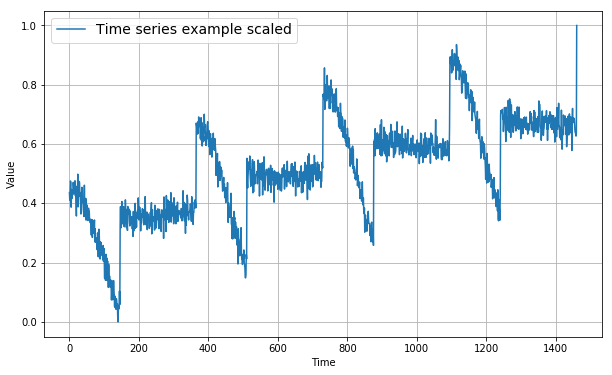

In [2]:
# Define the time series
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * (np.sqrt(time))

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# The time series
time = np.arange(4 * 365 + 1)
baseline = 10
series = baseline + trend(time,0.5) + white_noise(time, noise_level=1, seed=0) + seasonality(time, period=365, amplitude=10, phase=0)
# Normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(series.reshape(-1,1))
series = scaler.transform(series.reshape(-1,1))[0:,0]
#Plot
plt.figure(figsize=(10, 6))
plot_series(time, series, label='Time series example scaled')
plt.show()

In [3]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

# Reset states on epoch end
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [4]:
# Train and validation split
x_train = time[:1000]
y_train = series[:1000]
x_val = time[1000:]
y_val = series[1000:]
# Train and val sets
window_size = 30
train_set = sequential_window_dataset(y_train, window_size=30) 
val_set = sequential_window_dataset(y_val, window_size=30)

In [8]:
# Model fitting: LSTM
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  tf.keras.layers.LSTM(100, return_sequences=True, stateful=True),
  tf.keras.layers.Dense(units=1)
])

model.compile(loss=tf.keras.losses.Huber(),
             optimizer='adam',
             metrics=['mae'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "lstm_checkpoint.h5", save_best_only=True)
reset_states = ResetStatesCallback()

model.fit(train_set, epochs=200, validation_data=val_set,
          callbacks=[early_stopping, reset_states, model_checkpoint])

Epoch 1/200
33/33 [==============================] - 13s 409ms/step - loss: 0.0092 - mae: 0.0968 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/200
33/33 [==============================] - 2s 76ms/step - loss: 0.0032 - mae: 0.0597 - val_loss: 0.0014 - val_mae: 0.0345
Epoch 3/200
33/33 [==============================] - 2s 75ms/step - loss: 0.0029 - mae: 0.0561 - val_loss: 0.0013 - val_mae: 0.0332
Epoch 4/200
33/33 [==============================] - 3s 79ms/step - loss: 0.0025 - mae: 0.0525 - val_loss: 0.0013 - val_mae: 0.0321
Epoch 5/200
33/33 [==============================] - 2s 74ms/step - loss: 0.0023 - mae: 0.0495 - val_loss: 0.0012 - val_mae: 0.0315
Epoch 6/200
33/33 [==============================] - 2s 73ms/step - loss: 0.0021 - mae: 0.0477 - val_loss: 0.0012 - val_mae: 0.0312
Epoch 7/200
33/33 [==============================] - 3s 80ms/step - loss: 0.0020 - mae: 0.0466 - val_loss: 0.0012 - val_mae: 0.0309
Epoch 8/200
33/33 [==============================] - 3s 82ms/step 

In [9]:
model = tf.keras.models.load_model("lstm_checkpoint.h5")

0.0018313812


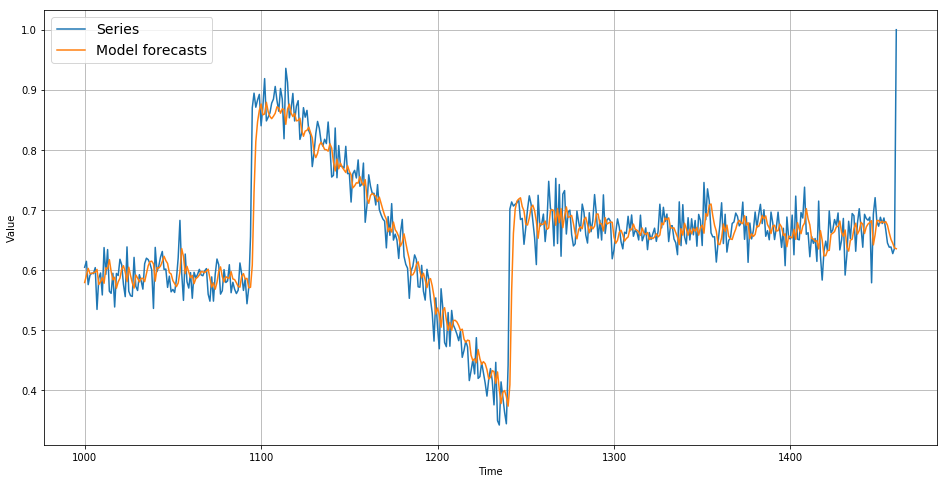

In [10]:
model.reset_states()
rnn_forecasts = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecasts = rnn_forecasts[0, 1000-1:-1, 0]
plt.figure(figsize=(16,8))
plot_series(x_val, y_val, label='Series')
plot_series(x_val, rnn_forecasts, label='Model forecasts')
print(tf.keras.metrics.mean_squared_error(y_val, rnn_forecasts).numpy())

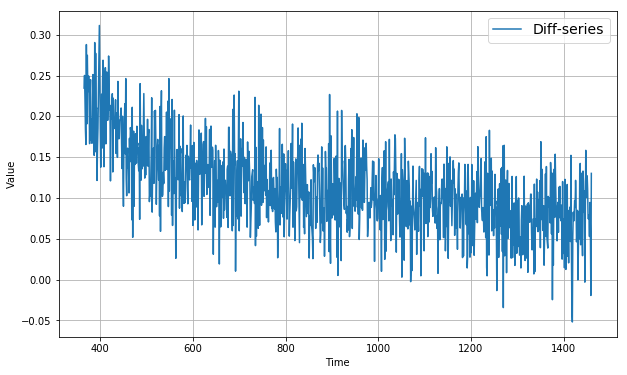

In [11]:
# Differencing
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10,6))
plot_series(diff_time, diff_series, label='Diff-series')

# Train and validation split for diff data
diff_y_train = diff_series[:1000-365]
diff_y_val = diff_series[1000-365:]
# Train and val sets
window_size = 30
diff_train_set = sequential_window_dataset(diff_y_train, window_size=30) 
diff_val_set = sequential_window_dataset(diff_y_val, window_size=30)

In [12]:
# Model fitting: stateful RNN
model2 = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  tf.keras.layers.LSTM(100, return_sequences=True, stateful=True),
  tf.keras.layers.Dense(units=1)
])

model2.compile(loss=tf.keras.losses.Huber(),
             optimizer='adam',
             metrics=['mae'])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
reset_states = ResetStatesCallback()

model2.fit(diff_train_set, epochs=200, validation_data=diff_val_set,
          callbacks=[early_stopping, reset_states, model_checkpoint])

Epoch 1/200
21/21 [==============================] - 8s 399ms/step - loss: 0.0036 - mae: 0.0614 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/200
21/21 [==============================] - 1s 53ms/step - loss: 0.0016 - mae: 0.0430 - val_loss: 8.2241e-04 - val_mae: 0.0326
Epoch 3/200
21/21 [==============================] - 1s 51ms/step - loss: 0.0018 - mae: 0.0452 - val_loss: 8.2430e-04 - val_mae: 0.0322
Epoch 4/200
21/21 [==============================] - 1s 51ms/step - loss: 0.0015 - mae: 0.0416 - val_loss: 8.3140e-04 - val_mae: 0.0324
Epoch 5/200
21/21 [==============================] - 1s 55ms/step - loss: 0.0014 - mae: 0.0400 - val_loss: 8.0627e-04 - val_mae: 0.0321
Epoch 6/200
21/21 [==============================] - 1s 53ms/step - loss: 0.0014 - mae: 0.0398 - val_loss: 8.1090e-04 - val_mae: 0.0324
Epoch 7/200
21/21 [==============================] - 1s 54ms/step - loss: 0.0014 - mae: 0.0395 - val_loss: 8.2588e-04 - val_mae: 0.0328
Epoch 8/200
21/21 [========================

In [13]:
model2 = tf.keras.models.load_model("my_checkpoint.h5")

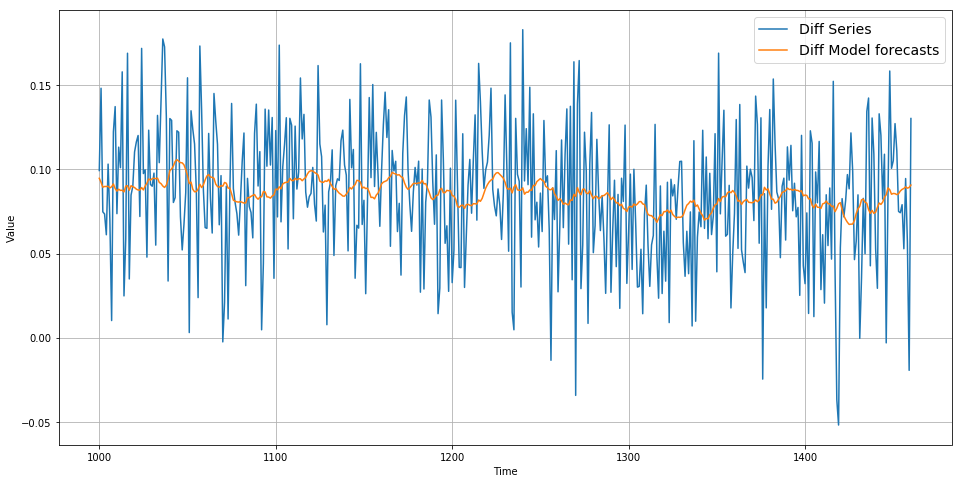

In [14]:
model2.reset_states()
diff_rnn_forecasts = model2.predict(diff_series[np.newaxis, :, np.newaxis])
diff_rnn_forecasts = diff_rnn_forecasts[0, 1000-365-1:-1, 0]
plt.figure(figsize=(16,8))
plot_series(x_val, diff_y_val, label='Diff Series')
plot_series(x_val, diff_rnn_forecasts, label='Diff Model forecasts')

0.0015845520278797685


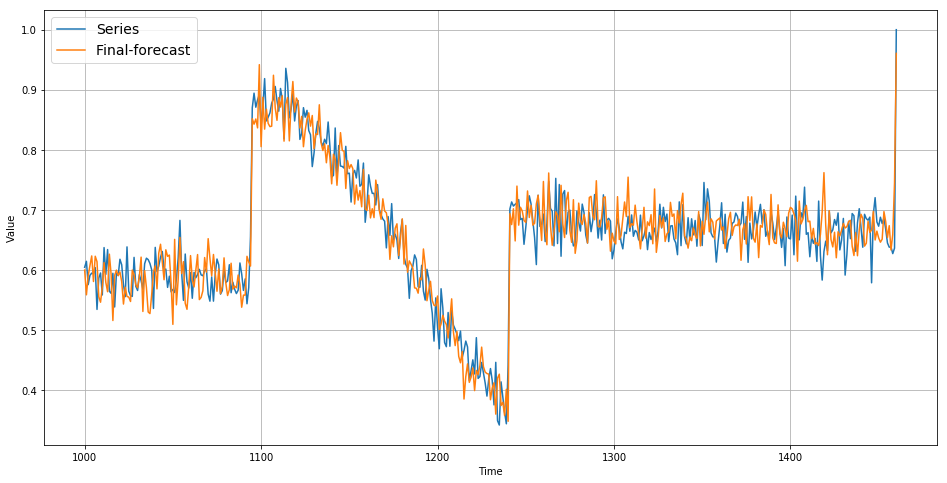

In [15]:
# De-differencing
final_forecast = diff_rnn_forecasts + series[1000-365:1000-365+len(y_val)]
plt.figure(figsize=(16, 8))
plot_series(x_val, y_val, label="Series")
plot_series(x_val, final_forecast, label="Final-forecast")
print(tf.keras.metrics.mean_squared_error(y_val, final_forecast).numpy())